#%load_ext autoreload
#%autoreload 2

In [1]:
from theta.rtbm import RTBM
from theta.mathtools import normalization_consistency
import numpy as np
import copy
import pathlib
from time import time
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 4]

In [2]:
ndim = 1
nhid = 3
nevt = 1e3
rtbm = RTBM(ndim, nhid, 
            minimization_bound=50,
            gaussian_init=True,
            positive_T=True, 
            positive_Q=True,
            gaussian_parameters = {"mean" : 0.0, "std": 0.55},
            sampling_activation = "tanh"
           )
params_0 = copy.deepcopy(rtbm.get_parameters())

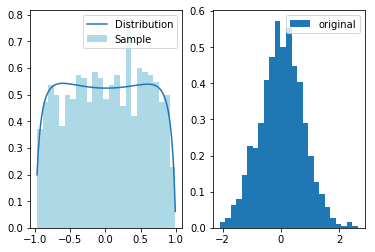

In [3]:
d = 0

def reorder(x, y, z):
    """ Return x, y, z as arrays ordered by x """
    r123 = np.array([ i for i in sorted(zip(x,y,z)) ]).T
    return r123

def get_values(n=nevt):
    xrand, xjac, original_r = rtbm.make_sample_rho(n)
    return reorder(xrand[:,d], xjac, original_r[:,d])

x_pre, y_pre, ordered_r = get_values()
        
plt.subplot(1,2,1)
plt.hist(x_pre, bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x_pre, y_pre, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(ordered_r, bins=25, density=True, label="original")
_ = plt.legend()

Total loss: 288.67


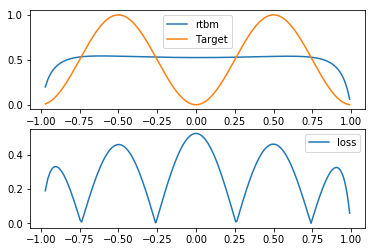

In [4]:
def my_fun(xarr):
    res = pow(np.sin(xarr*np.pi), 2)
    return res

def kl(x, y):
    return -(y*np.log(x))

def mse(x, y):
    return (x-y)**2

def labs(x,y):
    return np.abs(x-y)

loss = labs

my_y = my_fun(x_pre)
ll = loss(y_pre, my_y)

plt.subplot(2,1,1)
plt.plot(x_pre, y_pre, label="rtbm")
plt.plot(x_pre, my_y, label = "Target")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x_pre, ll, label="loss")
_ = plt.legend()
print(f"Total loss: {np.sum(ll):.2f}")

In [5]:
def generate_loss(xinput):

    def target_loss(params):
        if not rtbm.set_parameters(params):
            return np.NaN
        new_x, prob = rtbm.get_transformation(xinput.reshape(-1,1))
        y = my_fun(new_x[:,d])
        return np.sum(loss(prob, y))
    
    return target_loss

# GA parameters
iterations = 3000
original_sigma = 0.25
sigma = original_sigma
epsilon = 1e-3
mutation_rates = np.array([0.2, 0.4, 0.6, 0.8])
population_per_rate = 128
rates = np.concatenate([np.ones(population_per_rate)*mr for mr in mutation_rates])
ss = len(params_0)

min_bound, max_bound = rtbm.get_bounds()
repeats = 3

with Parallel(n_jobs=32) as parallel:
    
    best_parameters = params_0
    prev = time()
    
    x_input = ordered_r
    target_loss = generate_loss(x_input)
    loss_val = target_loss(best_parameters)
    print(f"Starting loss: {loss_val}")
    
    for it in range(iterations):
        
        p0 = copy.deepcopy(best_parameters)
        
        def compute_mutant(mrate):
            nm = int(ss*mrate)
            mut_idx = np.random.choice(ss, nm, replace=False)
            r1, r2 = np.random.rand(2, nm)*sigma

            mutant = copy.deepcopy(p0)
            var_plus = max_bound - p0
            var_minus = min_bound - p0
            mutant[mut_idx] += var_plus[mut_idx]*r1 + var_minus[mut_idx]*r2
            
            return target_loss(mutant), mutant
    
        parallel_runs = [delayed(compute_mutant)(rate) for rate in rates]
        result = parallel(parallel_runs)
        losses, mutants = zip(*result)
        
        best_loss = np.nanmin(losses)
        if best_loss < loss_val:
            loss_val = best_loss
            best_parameters = mutants[losses.index(best_loss)]
        else:
            sigma /= 2
            
        if it % 50 == 0:
            current = time()
            print(f"Iteration: {it}, best loss: {loss_val:.2f}, time: {current-prev:.2f}s")
            prev = current
            
        if sigma < epsilon:
            sigma = original_sigma
            print(f"Resetting sigma, with loss: {loss_val}", end="")
            repeats -= 1
            break

            _, _, x_input = get_values()
            target_loss = generate_loss(x_input)
            loss_val = target_loss(best_parameters)
            print(f" new loss: {loss_val}")
            
        
        if not repeats:
            print(f"No more repeats allowed, iteration: {it}, loss: {loss_val}")
            break
    rtbm.set_parameters(best_parameters)

Starting loss: 285.4958766890843
Iteration: 0, best loss: 277.54, time: 2.73s
Iteration: 50, best loss: 265.30, time: 110.95s
Iteration: 100, best loss: 259.89, time: 116.31s
Iteration: 150, best loss: 256.53, time: 114.46s
Iteration: 200, best loss: 250.92, time: 112.47s
Iteration: 250, best loss: 244.55, time: 108.69s
Iteration: 300, best loss: 236.94, time: 107.42s
Iteration: 350, best loss: 228.24, time: 105.57s
Iteration: 400, best loss: 218.12, time: 102.45s
Iteration: 450, best loss: 209.31, time: 101.62s
Iteration: 500, best loss: 200.17, time: 104.67s
Iteration: 550, best loss: 189.00, time: 103.59s
Iteration: 600, best loss: 179.69, time: 102.31s
Iteration: 650, best loss: 170.93, time: 102.40s
Iteration: 700, best loss: 160.98, time: 100.02s
Iteration: 750, best loss: 153.76, time: 100.09s
Resetting sigma, with loss: 149.8020155074952

In [ ]:
x_post, y_post, ordered_post = get_values(n=1e4)
#x_raw, y_raw = rtbm.get_transformation(x_input.reshape(-1,1))
#x_post, y_post, ordered_post = reorder(x_raw[:,d], y_raw, x_input)


plt.subplot(1,2,1)
plt.hist(x_post, bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x_post, y_post, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(ordered_post, bins=25, density=True, label="original")
_ = plt.legend()

Total loss: 288.6724734222376


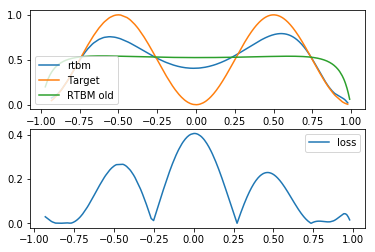

In [9]:
my_y_post = my_fun(x_post)
ll_post = loss(my_y_post, y_post)


plt.subplot(2,1,1)
plt.plot(x_post, y_post, label="rtbm")
plt.plot(x_post, my_y_post, label = "Target")
plt.plot(x_pre, y_pre, label="RTBM old")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x_post, ll_post, label="loss")
_ = plt.legend()
name_fig=pathlib.Path("perfect_fit_tanh_nh=3-sabado.png")
if name_fig.exists():
    print("WARNING: Image not saved")
else:
    plt.savefig(str(name_fig))
print(f"Total loss: {np.sum(ll)}")

#### Notas:

- Cuando usamos `minmax`, estamos cambiando, cada vez que entrenamos, el rango de acción. Por tanto, para entrenar con minmax tendríamos que generar datos en cada step o definir desde el principio donde están el máximo y el mínimo. ¿Se puede hacer esto? ¿Podemos controlar con los boundaries dónde están el máximo y el mínimo?
- Cuando usamos `sigmoid` o `tanh` el entrenamiento funciona fatal. ¿Podemos encontrar alguna forma mejor de hacerlo?
- Con `tanh`, de todas formas, logramos mejor entrenamiento que con `sigmoid`. _At the end of the day_ el único punto relevante es que los límites de integración sean 1) fijos 2) finitos así que so far so good. Seguramente `sigmoid` sea igualmente bueno pero el estado inicial puede ser más important. Con `nh=2` obtenemos un buen fit para el seno (4 picos).
- No estoy seguro de por qué no está corriendo todo lo en paralelo que podría? Me confunde que a veces lo haga sin embargo. Claramente hay un problema con `joblib` y `jupyter` que quizá esté relacionado con el uso de `autoreload`. Probemos a comentarlo \<RELLENAR ESTO CON EL RESULTADO\>